<a href="https://colab.research.google.com/github/amalvarezme/AnaliticaDatos/blob/master/Dashboards/Ejemplo_Dashboard_PrediccionCovid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ejemplo ilustrativo para la creación de dashboards con Python y Dash.

Desarrollado por Camilo Pelaez `cpelaezg@unal.edu.co` y Andrés Marino Álvarez `amalvarezme@unal.edu.co`.


## Instalar Dash en Colaboratory

La línea `pip install jupyter-dash -q` permite instalar la versión de Dash propia del compilador jupyter en Colab.


In [ ]:
pip install jupyter-dash -q

## Importar librerías

In [ ]:
from jupyter_dash import JupyterDash  # importa librería para usar propiedades de dash en jupiter
import dash 
import dash_html_components as html #importar componentes html en dash
import dash_core_components as dcc #importar componentes dash
from dash.dependencies import Output, Input # Entradas y salidas para las graficas interactivas
import plotly.express as px # importar libreria graficas express
import plotly.graph_objects as go # importar libreria graficas Graph Objects
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt 
import datetime
import base64 # se usa para codificar el logo
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.svm import SVR
from tensorflow import keras

%matplotlib inline

import warnings
warnings.filterwarnings("ignore") # nunca imprima advertencias coincidentes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  after removing the cwd from sys.path.


- Se descargan los datos históricos de Covid19:

In [ ]:
# Descargar datos covid ---------------------------------------------------------------------------------------------------------------------------------------------------------------
# Datos CSSEGISandData ----------------------------------------------------------------------------------------------------------------------------------------------------------------
Xd = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv") # leer los datos
# -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
Xd.head() # Mostrar los datos

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,12/4/21,12/5/21,12/6/21,12/7/21,12/8/21,12/9/21,12/10/21,12/11/21,12/12/21,12/13/21,12/14/21,12/15/21,12/16/21,12/17/21,12/18/21,12/19/21,12/20/21,12/21/21,12/22/21,12/23/21,12/24/21,12/25/21,12/26/21,12/27/21,12/28/21,12/29/21,12/30/21,12/31/21,1/1/22,1/2/22,1/3/22,1/4/22,1/5/22,1/6/22,1/7/22,1/8/22,1/9/22,1/10/22,1/11/22,1/12/22
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,5,5,...,157431,157454,157499,157508,157542,157585,157603,157611,157633,157648,157660,157665,157725,157734,157745,157787,157797,157816,157841,157878,157887,157895,157951,157967,157998,158037,158056,158084,158107,158189,158183,158205,158245,158275,158300,158309,158381,158394,158471,158511
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,201402,201730,201902,202295,202641,202863,203215,203524,203787,203925,204301,204627,204928,205224,205549,205777,205897,206273,206616,206935,207221,207542,207709,207709,208352,208899,208899,210224,210224,210885,210885,212021,212021,213257,214905,214905,219694,220487,222664,224569
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,211297,211469,211662,211859,212047,212224,212434,212652,212848,213058,213288,213533,213745,214044,214330,214592,214835,215145,215430,215723,216098,216376,216637,216930,217265,217647,218037,218432,218818,219159,219532,219953,220415,220825,221316,221742,222157,222639,223196,223806
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,18010,18010,18631,18815,18815,19272,19440,19440,19440,19440,20136,20136,20549,20549,20549,20549,21062,21062,21372,21571,21730,21730,21730,22332,22540,22823,23122,23740,23740,23740,24502,24802,25289,25289,26408,26408,26408,27983,28542,28899
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,65244,65259,65259,65301,65332,65346,65371,65397,65404,65404,65431,65565,65648,65760,65868,65938,66086,66566,67199,68362,70221,71142,71752,71752,76787,78475,79871,81593,82398,82920,83764,84666,86636,87625,88775,89251,89718,90316,91148,91907


In [ ]:
# Gráfico Georeferencia
day= '12/22/21' # Fecha que se quiere visualizar
fig =px.choropleth(Xd, locations="Country/Region", locationmode='country names', 
                     color=Xd[day], hover_name="Country/Region", 
                     hover_data = [Xd[day]],
                     projection="natural earth",
                     color_continuous_scale = px.colors.sequential.Blues,        
                     title='Mapa de Confirmados COVID 19 por país en ' + day) # Grafica choropleth de los casos confirmados de COVID 10 por pais georeferenciados.
fig.show() 

# Funciones

In [ ]:
def daily_increase(data):
    "Función para calcular el incremento diario"
    d = [] 
    for i in range(len(data)):
        if i == 0:
            d.append(data[0])
        else:
            d.append(data[i]-data[i-1])
    return d 

def moving_average(data, window_size): 
    "Función para calcular media por ventan"
    moving_average = []
    for i in range(len(data)):
        if i + window_size < len(data):
            moving_average.append(np.mean(data[i:i+window_size]))
        else:
            moving_average.append(np.mean(data[i:len(data)]))
    return moving_average

def get_country_info(country_name, dates):
    "Función para extraer información de un país"
    country_cases = []
    country_deaths = []
#     country_recoveries = [] 

    for i in dates:
        country_cases.append(confirmed_df[confirmed_df['Country/Region']==country_name][i].sum())
        country_deaths.append(deaths_df[deaths_df['Country/Region']==country_name][i].sum())
#         country_recoveries.append(recoveries_df[recoveries_df['Country/Region']==country_name][i].sum())
    return (country_cases, country_deaths)

def multi_step_forecasting(df, step):
  "Ventaneo de series, poniendo una cantidad de 'steps' anteriores al dato que desea ser predecido"
  df = df.sort_index()
  Colums = []
  for i in range(step): Colums.append('lags'+str(i))
  cont=0
  X = []
  X = df[cont:cont+step].T.set_axis(Colums, axis=1, inplace=False)
  for cont in range(1,len(df)-step):
    X = pd.concat([X,  df[cont:cont+step].T.set_axis(Colums, axis=1, inplace=False)], ignore_index=True)
  y = df.iloc[step:]

  return X, y

## Tratamiento de Datos:

- Para la visualización de los casos de Covid 19 en forma global se suman todos los países.

- Se aplica una función para extraer el incremento diario.

- Se aplica un filtrado por media móvil a los datos, usando una ventana de tiempo de 7 días.

- Adicionalmente, se crea un vector con las fechas, para hacer más entendibles los gráficos.

In [ ]:
# Datos--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
confirmed_df = Xd.copy() # Copiar los datos
Date = Xd.columns[4:] # Vector fechas
# Total casos confirmados en el mundo--------------------------------------------------------------------------------------------------------------------------------------------------
world_cases = []
for i in Date:
    confirmed_sum = confirmed_df[i].sum() #suma todos los paises por fecha
    world_cases.append(confirmed_sum)
# Aplicar funcion incremento diario----------------------------------------------------------------------------------------------------------------------------------------------------
world_daily_increase = daily_increase(world_cases) # incremento diario casos mundiales
# Filtrado por media movil-------------------------------------------------------------------------------------------------------------------------------------------------------------
window = 7 # Ventana para la media
world_confirmed_avg= moving_average(world_cases, window) # media movil casos muandiales
world_daily_increase_avg = moving_average(world_daily_increase, window) # media movil incremento diario casos mundiales
world_cases = np.array(world_cases) # convertir lista a arreglo
# Crear los vectores con fechas_-------------------------------------------------------------------------------------------------------------------------------------------------------
start = '2020/1/22'
start_date = datetime.datetime.strptime(start, '%Y/%m/%d')
adjusted_dates = []
for i in range(len(Date)):
    adjusted_dates.append((start_date + datetime.timedelta(days=i)).strftime('%Y/%m/%d'))
adjusted_dates = np.array(adjusted_dates).reshape(1, -1)[0]
# -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

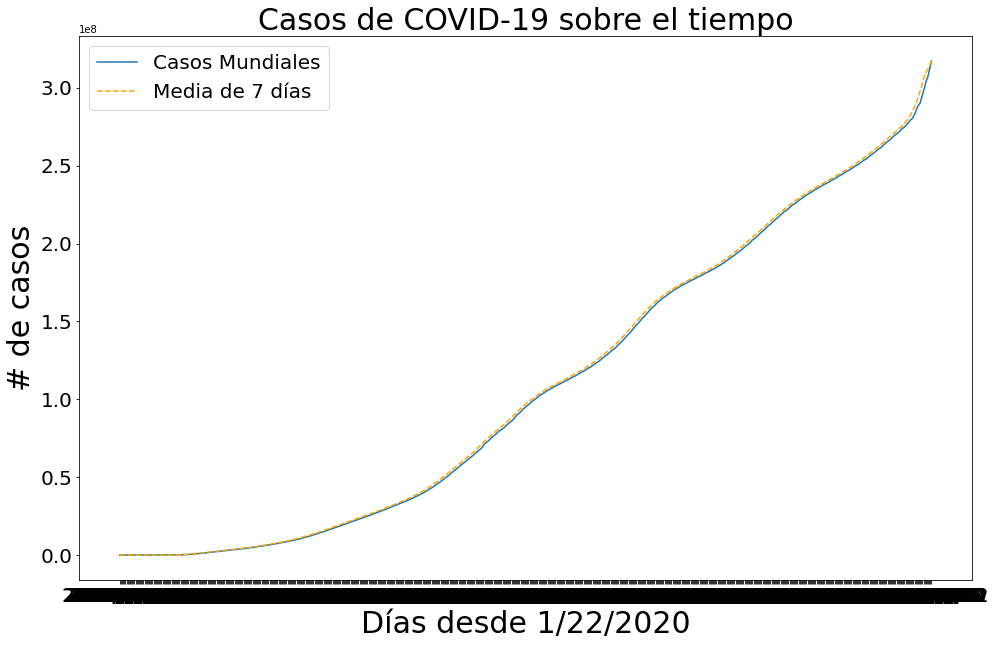

In [ ]:
# Figura Casos de COVID-19 sobre el tiempo plt
plt.figure(figsize=(16, 10))
plt.plot(adjusted_dates, world_cases)
plt.plot(adjusted_dates, world_confirmed_avg, linestyle='dashed', color='orange')
plt.title('Casos de COVID-19 sobre el tiempo', size=30)
plt.xlabel('Días desde 1/22/2020', size=30)
plt.ylabel('# de casos', size=30)
plt.legend(['Casos Mundiales', 'Media de {} días'.format(window)], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

xaxis_type = 'linear' # Variable para escala del grafico

# Figura Casos de COVID-19 sobre el tiempo go
fig_0 = go.Figure()
fig_0.add_trace(go.Scatter(x=adjusted_dates, y=world_cases, name='Casos Mundiales'))
fig_0.add_trace(go.Scatter(x=adjusted_dates, y= world_confirmed_avg, name='Media de {} días'.format(window), line=dict(color='firebrick', width=4,
                              dash='dash')))
fig_0.update_layout(title_text='Casos de COVID-19 sobre el tiempo', height=800)
fig_0.update_xaxes(title_text='Días desde 1/22/2020')
fig_0.update_yaxes(title_text='# de casos', type='linear' if xaxis_type == 'linear' else 'log')
fig_0.update_xaxes(rangeslider_visible=True)                 
fig_0.show() # Mostrar grafica

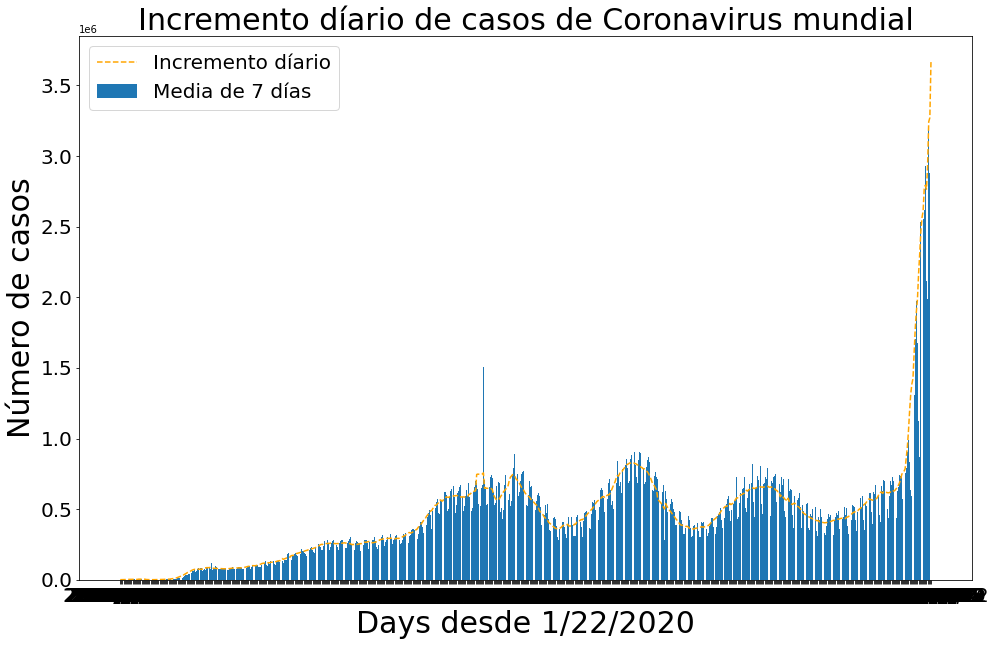

In [ ]:
# Figura Incremento díario de casos de Coronavirus mundial plt
plt.figure(figsize=(16, 10))
plt.bar(adjusted_dates, world_daily_increase)
plt.plot(adjusted_dates, world_daily_increase_avg, color='orange', linestyle='dashed')
plt.title('Incremento díario de casos de Coronavirus mundial', size=30)
plt.xlabel('Days desde 1/22/2020', size=30)
plt.ylabel('Número de casos', size=30)
plt.legend(['Incremento díario','Media de {} días'.format(window)], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

# Figura Incremento díario de casos de Coronavirus mundial go
fig_1= go.Figure()
trace1 = go.Bar(y=world_daily_increase,name='Incremento díario')
trace2 = go.Scatter(y=world_daily_increase_avg,name='Media de {} días'.format(window))
fig_1.add_traces([trace1, trace2])
fig_1.update_layout(title_text='Incremento díario de casos de Coronavirus mundial', height=800)
fig_1.update_xaxes(title_text='Days desde 1/22/2020')
fig_1.update_yaxes(title_text='Número de casos')
fig_1.update_xaxes(rangeslider_visible=True)
fig_1.show() # Mostrar grafica

# Descargar Base de Datos de muertes confirmadas por Covid-19:

In [ ]:
# Dataset muertes por covid -----------------------------------------------------------------------------------------------------------------------------------------------------------
# Datos CSSEGISandData ----------------------------------------------------------------------------------------------------------------------------------------------------------------
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
# -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
deaths_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,12/4/21,12/5/21,12/6/21,12/7/21,12/8/21,12/9/21,12/10/21,12/11/21,12/12/21,12/13/21,12/14/21,12/15/21,12/16/21,12/17/21,12/18/21,12/19/21,12/20/21,12/21/21,12/22/21,12/23/21,12/24/21,12/25/21,12/26/21,12/27/21,12/28/21,12/29/21,12/30/21,12/31/21,1/1/22,1/2/22,1/3/22,1/4/22,1/5/22,1/6/22,1/7/22,1/8/22,1/9/22,1/10/22,1/11/22,1/12/22
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,7312,7312,7316,7317,7319,7321,7324,7325,7328,7328,7329,7331,7332,7332,7333,7335,7335,7335,7341,7346,7348,7349,7354,7354,7355,7356,7356,7356,7356,7361,7364,7365,7367,7367,7368,7369,7373,7373,7374,7376
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3109,3110,3115,3122,3126,3128,3130,3132,3134,3140,3144,3152,3156,3158,3161,3166,3172,3178,3180,3181,3187,3189,3194,3194,3207,3212,3212,3217,3217,3220,3220,3224,3224,3228,3233,3233,3240,3241,3247,3253
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,6096,6103,6111,6114,6122,6126,6132,6137,6145,6151,6155,6165,6171,6175,6180,6184,6190,6198,6205,6213,6222,6229,6238,6246,6254,6263,6271,6276,6284,6291,6298,6303,6310,6318,6325,6330,6339,6349,6363,6372
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,132,132,133,133,133,133,133,133,133,133,134,134,134,134,134,134,137,137,138,139,139,139,139,139,140,140,140,140,140,140,140,141,141,141,141,141,141,141,141,141
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1735,1735,1735,1735,1735,1736,1737,1737,1737,1737,1737,1737,1737,1738,1738,1738,1738,1738,1741,1743,1746,1746,1749,1749,1756,1760,1764,1770,1772,1772,1775,1778,1789,1799,1809,1819,1826,1832,1840,1842


# Análisis Covid Colombia

- Con los dos datasets descargados, se aplica una función para extraer de estos la información de solo un país.

- Se separan por casos y muertes.

- Se alpican las funciones de incremento diario y media móvil.

- Se particiona una serie de tiempo en test, valid y train.

- Se hace un ventaneo de los conjuntos test, valid y train.

- Se entrena una red neuronal con los datos de la serie de tiempo.

- Se entrena un modelo SVM con kernel rbf con los datos de la serie de tiempo.

In [ ]:
# Extraer información de un país-------------------------------------------------------------------------------------------------------------------------------------------------------
country_info = get_country_info("Colombia", Date) # Extraer información país Colombia
# Separar datos por casos y muertes----------------------------------------------------------------------------------------------------------------------------------------------------
country_cases = country_info[0] # Casos en el país
country_deaths = country_info[1] # Muertes en el país
# Aplicar función incremento diario----------------------------------------------------------------------------------------------------------------------------------------------------
country_daily_cases = pd.DataFrame({"country_daily_cases": daily_increase(country_cases)}, index=adjusted_dates) # Incremento de los casos diarios
country_daily_death = pd.DataFrame({"country_daily_death": daily_increase(country_deaths)}, index=adjusted_dates) # Incremento mueretes diarias
# Filtrado por media móvil-------------------------------------------------------------------------------------------------------------------------------------------------------------
confirmed_avg = pd.DataFrame({"confirmed_avg": moving_average(country_cases, window)}, index=adjusted_dates) # Media móvil casos país
daily_cases_avg = pd.DataFrame({"daily_cases_avg": moving_average(daily_increase(country_cases), window)}, index=adjusted_dates) # Media móvil incremento casos diarios
daily_death_avg = pd.DataFrame({"daily_death_avg": moving_average(daily_increase(country_deaths), window)}, index=adjusted_dates) # Media móvil muertes diarias
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
fig_3= go.Figure(data=go.Scatter(x=adjusted_dates,y=country_cases, line=dict(color='royalblue', width=4), name="Casos confirmados en Colombia"))
fig_3.add_trace(go.Scatter(x=confirmed_avg.index, y=confirmed_avg.confirmed_avg,name="Media de 7 días",
                    line=dict(color='firebrick', width=4, dash='dash')))
fig_3.update_layout(title_text='Casos confirmados en Colombia', height=800)
fig_3.update_xaxes(rangeslider_visible=True,title_text='Días desde 1/22/2020')
fig_3.update_yaxes(title_text='# de casos')
fig_3.show() # Mostrar grafica

In [ ]:
fig_4= go.Figure(data=go.Scatter(x=country_daily_cases.index, y=country_daily_cases.country_daily_cases, line=dict(color='royalblue', width=4), name="Casos Confirmados en Colombia (Diariamente)"))
fig_4.add_trace(go.Scatter(x=daily_cases_avg.index, y=daily_cases_avg.daily_cases_avg, name="Media de 7 días",
                    line=dict(color='firebrick', width=4,
                              dash='dash')))
fig_4.update_layout(title_text='Casos diarios en Colombia', height=800)
fig_4.update_xaxes(rangeslider_visible=True,title_text='Días desde 1/22/2020')
fig_4.update_yaxes(title_text='# de casos')
fig_4.show() # Mostrar grafica

In [ ]:
fig_5= go.Figure(data=go.Scatter(x=country_daily_death.index, y=country_daily_death.country_daily_death, line=dict(color='royalblue', width=4), name="Muertes en Colombia (Diariamente)"))
fig_5.add_trace(go.Scatter(x=daily_death_avg.index , y=daily_death_avg.daily_death_avg ,name="Media de 7 días",
                    line=dict(color='firebrick', width=4,
                              dash='dash')))
fig_5.update_layout(title_text='Muertes en Colombia', height=800)
fig_5.update_xaxes(rangeslider_visible=True,title_text='Días desde 1/22/2020')
fig_5.update_yaxes(title_text='# de casos')
fig_5.show() # Mostrar grafica

## Partición de los datos
Se particionan los datos en test, train y valid con la distribución de:

Train: $70\%$

Valid: $20\%$

Test: $10\%$

Para esto se calculan las fechas correspondientes para el inicio y fin de cada uno de los conjuntos de datos. 

Para train se toma desde el inicio hasta la fecha que abarque de forma continua el $70\%$ del total.

Para valid se toma desde las fecha siguiente a la fecha final del train hasta abarcar de forma continua el $20\%$ del total.

Para test se toman los datos restantes.


In [ ]:
Datos = daily_cases_avg # Elegir serie de tiempo
#---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Total = len(Date)
# Partimos en conjuntos de train/valid/test--------------------------------------------------------------------------------------------------------------------------------------------
fin_train = int(Total*0.7)
fin_valid = (int(Total*0.7)+int(Total*0.2))
Datos_train = Datos[:fin_train]
Datos_valid = Datos[fin_train:fin_valid]
Datos_test =  Datos[fin_valid:]
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
print(f"Fechas train      : {Datos_train.index.min()} --- {Datos_train.index.max()}")
print(f"Fechas validación : {Datos_valid.index.min()} --- {Datos_valid.index.max()}")
print(f"Fechas test       : {Datos_test.index.min()} --- {Datos_test.index.max()}")
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Fechas train      : 2020/01/22 --- 2021/06/09
Fechas validación : 2021/06/10 --- 2021/10/31
Fechas test       : 2021/11/01 --- 2022/01/12


## Ventaneo

- El ventaneo es un proceso para la estimación usando datos anteriores, este usa series de tiempo, esta se reorganiza en lags, donde el número de lags representa la cantidad de datos previos que se usa para la estimación.

- Para organizar la serie de tiempo como un dataset, se toma desde el inicio de la serie una cantidad `x` de lags y el siguiente dato en la serie sería el valor a estimar.

-Por ejemplo: para estimación el dia 15 con 3 lags, los lags serian los días 12, 13, 14.

-Este conjunto de lags representan una entidad (muestra) en el dataset. 

-Para la siguiente entidad se avanza en la serie de tiempo, tomando el segundo lag de la entidad anterior, como el primero, el tercero como el segundo y asi sucesivamente hasta que el valor a estimar de la anterior entidad sea el último lag de la nueva entidad (como corriendo los lags hacia la izquierda rellenando el espacio faltante con el valor a estimar de la entidad anterior).

In [ ]:
window_width=7
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
X_train, y_train = multi_step_forecasting(Datos_train, window_width)
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
X_valid, y_valid = multi_step_forecasting(Datos_valid, window_width)
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
X_test, y_test = multi_step_forecasting(Datos_test, window_width)
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
X_test.head()
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

,lags0,lags1,lags2,lags3,lags4,lags5,lags6
0,1807.857143,1854.571429,1965.142857,2074.285714,2179.428571,2262.857143,2336.285714
1,1854.571429,1965.142857,2074.285714,2179.428571,2262.857143,2336.285714,2414.714286
2,1965.142857,2074.285714,2179.428571,2262.857143,2336.285714,2414.714286,2472.428571
3,2074.285714,2179.428571,2262.857143,2336.285714,2414.714286,2472.428571,2447.000000
4,2179.428571,2262.857143,2336.285714,2414.714286,2472.428571,2447.000000,2417.857143


In [ ]:
y_test.head()

,daily_cases_avg
2021/11/08,2414.714286
2021/11/09,2472.428571
2021/11/10,2447.000000
2021/11/11,2417.857143
2021/11/12,2343.142857


## Entrenamiento y predicción.

### Red Neuronal

- Se utilizará una red neuronal para predecir los datos de Colombia.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 7)                 0         
                                                                 
 dense (Dense)               (None, 100)               800       
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dense_2 (Dense)             (None, 20)                1020      
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 6,891
Trainable params: 6,891
Non-trainable params: 0
_________________________________________________________________


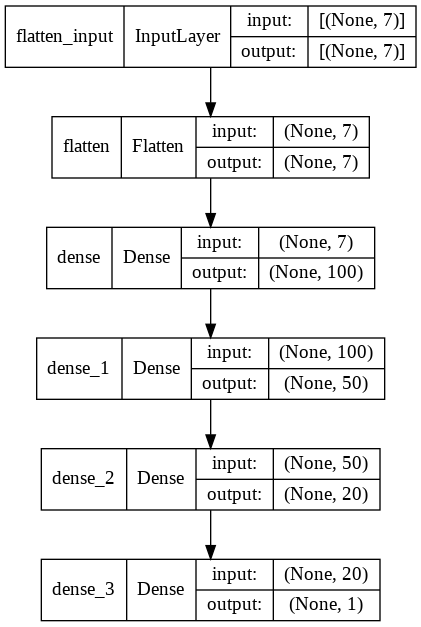

In [ ]:
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Definimos un modelo secuencial-------------------------------------------------------------------------------------------------------------------------------------------------------
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[window_width]),
    keras.layers.Dense(100, 'relu'),
    keras.layers.Dense(50, 'relu'),
    keras.layers.Dense(20, 'relu'),
    keras.layers.Dense(1)
])
# compilamos el modelo NN--------------------------------------------------------------------------------------------------------------------------------------------------------------
optimizer = keras.optimizers.Adam(lr=0.05)
model.compile(loss="mae", optimizer=optimizer)
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
model.summary()
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
keras.utils.plot_model(model, "my_model_series.png", show_shapes=True)
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# Entrenamos el modelo---------------------------------------------------------------------------------------------------------------------------------------------------
epochs = 256
history = model.fit(X_train, y_train, epochs=epochs,
                    validation_data=(X_valid, y_valid))
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Epoch 1/256
16/16 [==============================] - 1s 16ms/step - loss: 8784.0439 - val_loss: 882.7515
Epoch 2/256
16/16 [==============================] - 0s 5ms/step - loss: 885.4760 - val_loss: 632.5042
Epoch 3/256
16/16 [==============================] - 0s 4ms/step - loss: 871.8519 - val_loss: 2260.2283
Epoch 4/256
16/16 [==============================] - 0s 4ms/step - loss: 908.6997 - val_loss: 512.8129
Epoch 5/256
16/16 [==============================] - 0s 5ms/step - loss: 700.2283 - val_loss: 1181.3612
Epoch 6/256
16/16 [==============================] - 0s 5ms/step - loss: 583.5490 - val_loss: 756.3853
Epoch 7/256
16/16 [==============================] - 0s 5ms/step - loss: 410.8622 - val_loss: 277.6696
Epoch 8/256
16/16 [==============================] - 0s 4ms/step - loss: 584.2452 - val_loss: 841.1447
Epoch 9/256
16/16 [==============================] - 0s 4ms/step - loss: 677.6357 - val_loss: 311.3341
Epoch 10/256
16/16 [==============================] - 0s 5ms/step - l

In [ ]:
# verificamos evaluación del modelo-------------------------------------------------------------------------------------------------------------------------------------------------
nn_pred = model.predict(X_test)
print('MAE:',np.mean(keras.losses.mean_absolute_error(y_test, nn_pred)))
#-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

MAE: 327.4007


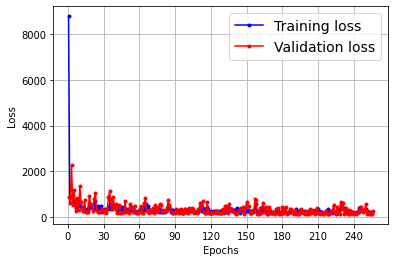

In [ ]:
# Definimos una función para plot de curvas de aprendizaje------------------------------------------------------------------------------------------------------------------------------
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
# graficamos curvas de aprendizaje-----------------------------------------------------------------------------------------------------------------------------------------------------
plot_learning_curves(history.history['loss'], history.history['val_loss'])
plt.show()
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
fig_7= go.Figure(data=go.Scatter(x=y_test.index, y=nn_pred[:,0] , name="Predicción NN", line=dict(color='firebrick', width=4, dash='dash')))
fig_7.add_trace(go.Scatter(x=y_test.index, y=y_test.daily_cases_avg, line=dict(color='royalblue', width=4), name="Casos Confirmados en Colombia (Diariamente)"))
fig_7.update_layout(title_text='Predicción NN casos diarios Colombia', height=800)
fig_7.update_xaxes(rangeslider_visible=True,title_text='Días desde '+y_test.index.min())
fig_7.update_yaxes(title_text='# de casos')
fig_7.show() # Mostrar grafica

### SVM

In [ ]:
# Definimos un modelo---------------------------------------------------------------------------------------------------------------------------------------------------------------------
modelsvr = SVR(kernel='rbf')
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
parameters = {'C':[1e2, 2e3, 5e3, 1e4],
              'epsilon':[0.001,0.005,0.01,0.05,0.1,0.5,0.8]}
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
scoring = {'absolute':'neg_mean_absolute_error','squares':'neg_mean_squared_error'}# Diccionario metricas error https://scikit-learn.org/stable/modules/model_evaluation.html
grid_search = GridSearchCV(modelsvr, parameters, n_jobs=-1, cv=5, scoring=scoring, verbose=10, refit='absolute')# refit se escoje la metrica con la que desea optimizar 
grid_search.fit(X_train, y_train) # Validación cruzada
y_pred = grid_search.predict(X_test) # Predicción mejores Hiper-parametros
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
list_hyper=grid_search.best_params_ # Guardar mejores parametros
print('MAE:',np.mean(keras.losses.mean_absolute_error(y_test, y_pred)))
print(list_hyper)
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Fitting 5 folds for each of 28 candidates, totalling 140 fits
MAE: 7327.1781129360825
{'C': 10000.0, 'epsilon': 0.5}


In [ ]:
# Definimos un modelo---------------------------------------------------------------------------------------------------------------------------------------------------------------------
svm_confirmed = SVR(kernel='rbf', C=list_hyper['C'], epsilon=list_hyper['epsilon'])
# Entrenar modelo-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
svm_confirmed.fit(X_train, y_train)
#-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

SVR(C=10000.0, epsilon=0.5)

In [ ]:
# Verificamos evluación del modelo-----------------------------------------------------------------------------------------------------------------------------------------------------
svm_pred = svm_confirmed.predict(X_test)
print('MAE:',np.mean(keras.losses.mean_absolute_error(y_test, svm_pred)))
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

MAE: 7327.1781129360825


In [ ]:
fig_6= go.Figure(data=go.Scatter(x=y_test.index , y=svm_pred , name="Predicción SVM", line=dict(color='firebrick', width=4, dash='dash')))
fig_6.add_trace(go.Scatter(x=y_test.index, y=y_test.daily_cases_avg, line=dict(color='royalblue', width=4), name="Casos Confirmados en Colombia (Diariamente)"))
fig_6.update_layout(title_text='Predicción SVM casos diarios Colombia', height=800)
fig_6.update_xaxes(rangeslider_visible=True,title_text='Días desde '+y_test.index.min())
fig_6.update_yaxes(title_text='# de casos')
fig_6.show() # Mostrar grafica

# Instalar componetes para ver el Dash de forma remota en Colab

- La línea `pip install pyngrok` permite intalar una API de [ngrok](https://ngrok.com/) en Python. 

- ngrok es una herramienta de proxy inverso que abre túneles seguros desde URL públicas a localhost, perfecta para exponer servidores web locales, habilitar el acceso SSH, probar chatbots, hacer demostraciones desde su propia máquina y más.

- Además, permite una integración nativa de Python a través de [pyngrok](https://pypi.org/project/pyngrok/).

In [ ]:
!pip install pyngrok

     |████████████████████████████████| 745 kB 5.2 MB/s 
  Created wheel for pyngrok: filename=pyngrok-5.1.0-py3-none-any.whl size=19007 sha256=0fd725a2d310a7c0d0d66680f7b956cbef21fedcb93567040bdfcc0ba28bfc18
  Stored in directory: /root/.cache/pip/wheels/bf/e6/af/ccf6598ecefecd44104069371795cb9b3afbcd16987f6ccfb3
Successfully built pyngrok


## Autenticación: Creación de cuenta ngrok.

Al ingresar a [ngrok](https://dashboard.ngrok.com/login), vemos la siguiente pantalla para registrarse.


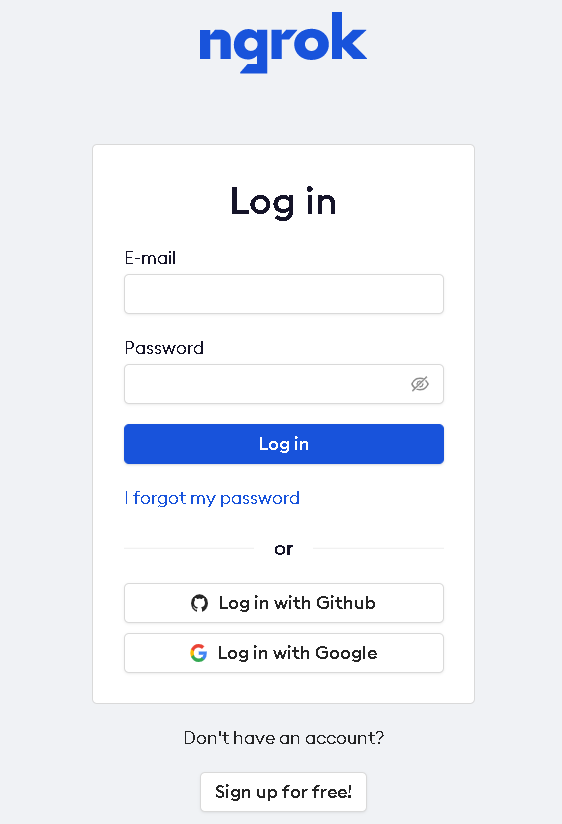

Al registrarnos, nos enviará a esta página.

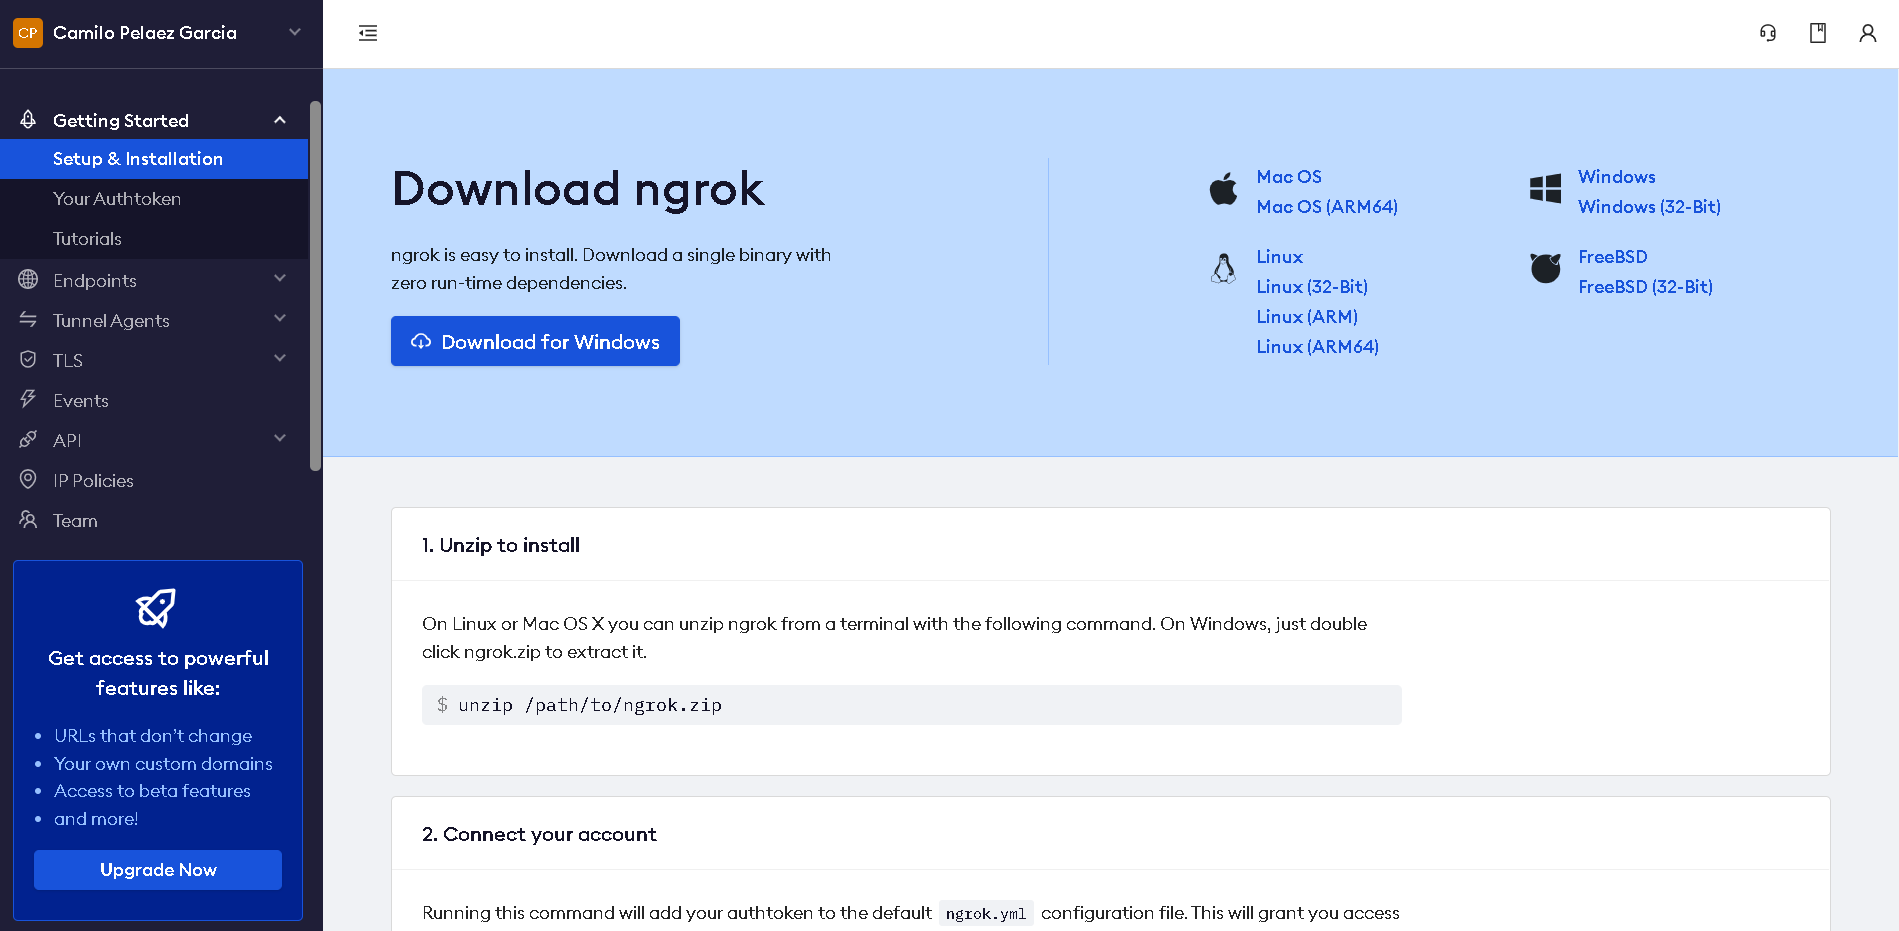

En `Getting Started`, seleccionamos `Your Authtoken`.

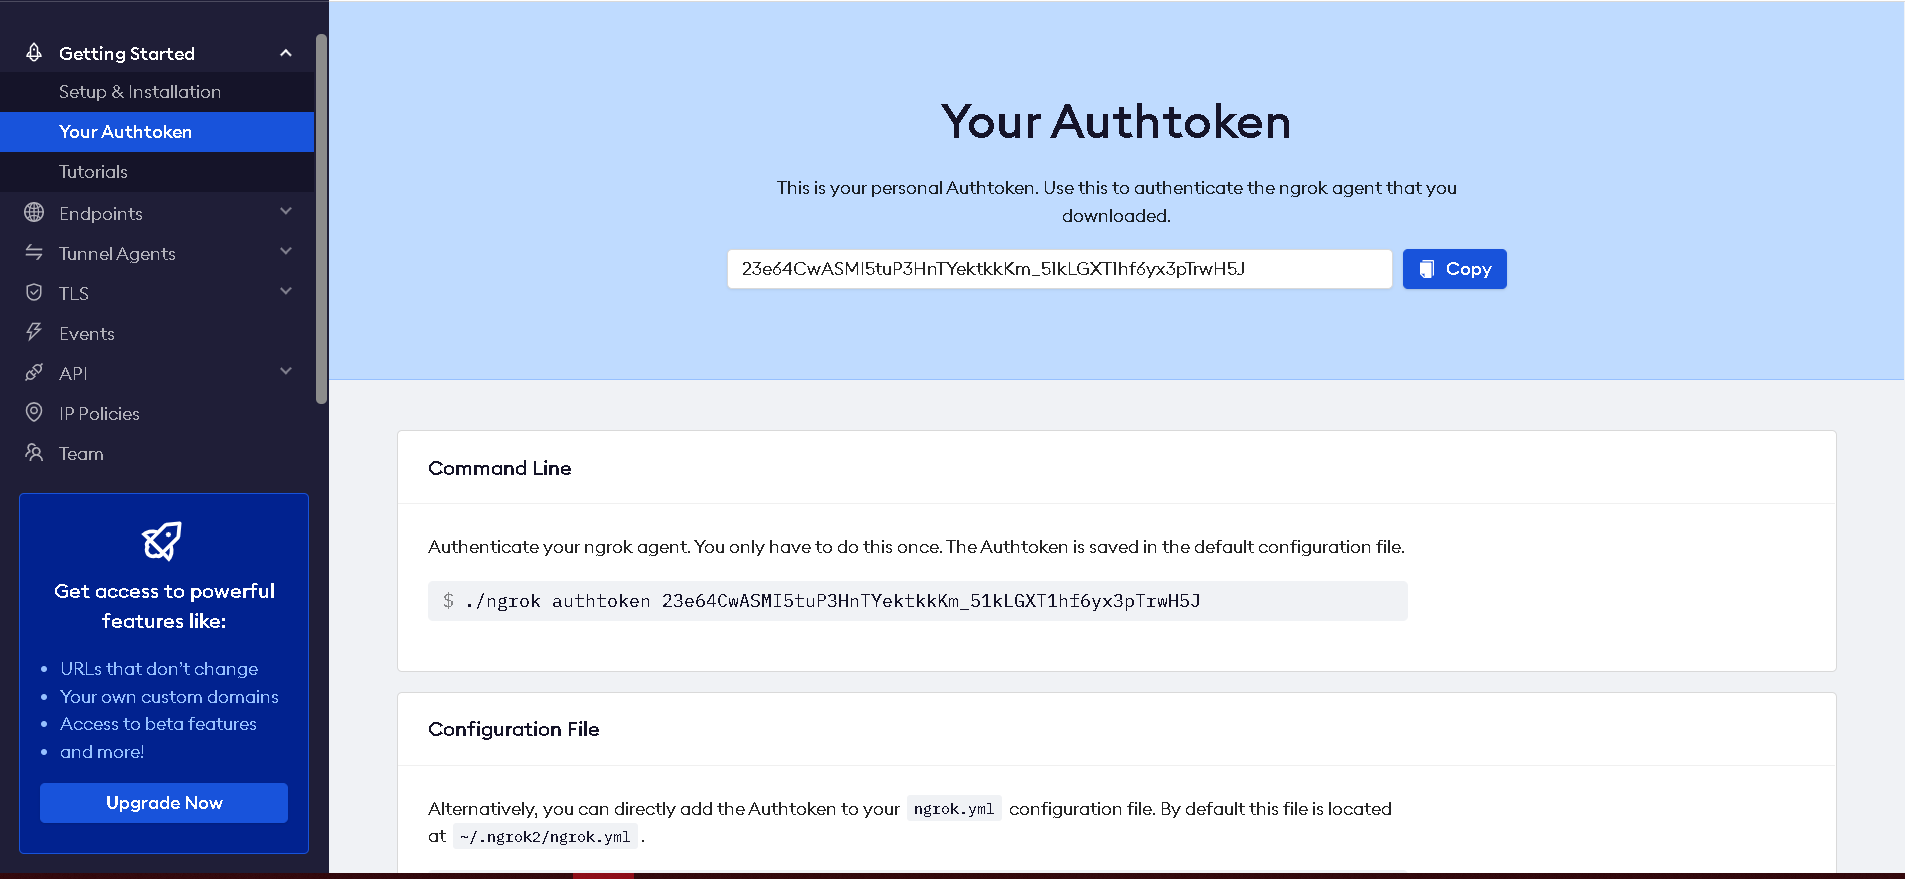

Y así obtenemos nuestro token, este se reemplaza por el que se encuentra en la siguiente línea.

In [ ]:
!ngrok authtoken 23e64CwASMI5tuP3HnTYektkkKm_51kLGXT1hf6yx3pTrwH5J # Insertar el token relacionado a tu cuenta ngrok

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


## Creación del túnel `http`.

In [ ]:
from pyngrok import ngrok
public_url = ngrok.connect(8000, "http")
print(public_url)

NgrokTunnel: "http://85bf-34-68-51-217.ngrok.io" -> "http://localhost:8000"


# Mostrar en dash

Configurar Style

In [ ]:
!git clone https://github.com/cmosquerat/style assets

Cloning into 'assets'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 13 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (13/13), done.


Descargar Logo Unal

In [ ]:
! wget --no-check-certificate --content-disposition -O logo.png https://i.pinimg.com/originals/98/3d/fb/983dfbcc82b24dd28b2e6dc4aeec7c79.png

--2022-01-13 23:10:33--  https://i.pinimg.com/originals/98/3d/fb/983dfbcc82b24dd28b2e6dc4aeec7c79.png
Resolving i.pinimg.com (i.pinimg.com)... 104.18.14.176, 104.18.15.176, 2600:1407:3c00:1483::1931, ...
Connecting to i.pinimg.com (i.pinimg.com)|104.18.14.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25876 (25K) [image/png]
Saving to: ‘logo.png’

logo.png            100%[===================>]  25.27K  --.-KB/s    in 0s      

2022-01-13 23:10:33 (74.5 MB/s) - ‘logo.png’ saved [25876/25876]



Ir a este link para ver página

In [ ]:
public_url

<NgrokTunnel: "http://85bf-34-68-51-217.ngrok.io" -> "http://localhost:8000">

In [ ]:
image_filename = 'logo.png' # Logo Unal, remplazar con el logo propio
encoded_image = base64.b64encode(open(image_filename, 'rb').read()) # Abrir imagen(logo)
external_stylesheets = [ # Plantilla estilo CSS
    {
        "href": "https://fonts.googleapis.com/css2?"
                "family=Lato:wght@400;700&display=swap",
        "rel": "stylesheet",
    },
]

app = JupyterDash(__name__, external_stylesheets=external_stylesheets)
# Crear objeto JupyterDash para visualización en el entorno
# Crear un layout para contener el texto y gráficas.
# app.title = "Trabajo de analítica de datos" # Crear titulo en el layaut
# Crea Div para separar secciones, no tiene ningún efecto sobre el contenido o el diseño hasta que se le aplica estilo usando CSS.
app.layout =html.Div(
    children=[
        html.Div( # Div para seccion encabezado
            children=[
                html.Img(src='data:image/png;base64,{}'.format(encoded_image.decode()),width="333",height="200",className="header-emoji"), # Imagen
                html.H1( # Componente Html para crear título
                    children="Dashboard Covid-19", className="header-title"
                ),
                html.P( # Componente Html para crear parrafo 
                    children=['Universidad Nacional de Colombia', html.Br(), 'cmosquerat, cpelaezg'], # Texto parrafo
                    className="header-description", # Estilo
                ), # Creacion Parrafo 
            ],
            className="header", # Estilo del Div
        ),

html.Div(className='eight columns div-for-charts bg-grey', # Estilo del Div
      children=[ # Georreferenciación
        dcc.Graph(id='graph-with-slider', # Sección Gráfica
                config={'displayModeBar': False}, # Opciones de configuración de Plotly.js.(config es un dictado con claves)
                    # displayModeBar muestra la barra de modo (True, False o 'hover').
                className="card"),
        dcc.Slider( # Sección barra deslizable
                id='year-slider',
                min=0,
                max=len(Date),
                value=len(Date)-1,
                marks={str(i): str(Date[i]) for i in range(0,len(Date),30)}, # Opciones
                step=30
        ),
 ]),
html.Div([  
    html.Div(children=[ # Casos sobre el tiempo, cambio escala logaridmica
        dcc.Graph(id='CasesOverTime1', # Sección Gráfica
            config={'displayModeBar': False}), # Opciones de configuración de Plotly.js.(config es un dictado con claves)
                    # displayModeBar muestra la barra de modo (True, False o 'hover').
        dcc.RadioItems( # Sección cheks 
            id='yaxis-type',
            options=[{'label': i, 'value': i} for i in ['linear', 'log']], # Opciones
            value='linear')  # Sección Gráfica
            ], style={'width': '48%', 'display': 'inline-block'}, # Estilo para doble columna izq
        className="card"), # Estilo del Div
    html.Div( # Incremento diario
        dcc.Graph(id='WorldDailyIncreases1',# Sección Gráfica
            config={'displayModeBar': False}, # Opciones de configuración de Plotly.js.(config es un dictado con claves)
                    # displayModeBar muestra la barra de modo (True, False o 'hover').
            figure = fig_1,
            className="card"),
            style={'width': '48%', 'float': 'right', 'display': 'inline-block'} # Estilo para doble columna der
            ),
    html.Div([ # Graficas Colombia
        dcc.Dropdown( # Sección desplegable para elegir grafico
            id='crossfilter',
            options=[{'label': i, 'value': i} for i in ['Casos acumulados en Colombia', 'Casos diarios en Colombia', 'Muertes diarias en Colombia']], # Opciones
            value='Casos diarios en Colombia'), # seleccionado por defecto
        dcc.Graph(id='Colombia_graf',  # Sección Gráfica
            config={'displayModeBar': False},# Opciones de configuración de Plotly.js.(config es un dictado con claves)
                    # displayModeBar muestra la barra de modo (True, False o 'hover').
            className="card")
    ]),
    html.Div( # Grafica prediccion SVM
        dcc.Graph(id='Predict_SVM',  # Sección Gráfica
            config={'displayModeBar': False}, # Opciones de configuración de Plotly.js.(config es un dictado con claves)
                      # displayModeBar muestra la barra de modo (True, False o 'hover').
            figure = fig_6,
            className="card"),
        className ="six columns" 
          ),
    
    html.Div( # Grafica prediccion RNN
        dcc.Graph(id='Predict_RNN',  # Sección Gráfica
            config={'displayModeBar': False}, # Opciones de configuración de Plotly.js.(config es un dictado con claves)
                      # displayModeBar muestra la barra de modo (True, False o 'hover').
            figure = fig_7,
            className="card"),
        className ="six columns"
          ),
     ],
     className="row"         
     )

])
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# callback georeferenciacion ----------------------------------------------------------------------------------------------------------------------------------------------------------
@app.callback(    
    Output('graph-with-slider', 'figure'),
    Input('year-slider', 'value')) # Decorador app.callback se definen las entradas y salidas 
# En la salida(Output) se pone el id de la gráfica y "figure" que es lo que nos devuelve la función 
# En la entrada(Input) se pone el id del componente usado como interfaz y el atributo que da los valores por defecto "value"
def update_figure(day):
    
    fig_geo = fig =px.choropleth(Xd, locations="Country/Region", locationmode='country names', 
                     color=Xd[Date[day]], hover_name="Country/Region", 
                     hover_data = [Xd[Date[day]]],
                     projection="natural earth",
                     color_continuous_scale = px.colors.sequential.Blues,        
                     title='Mapa de Confirmados COVID 19 por pais en ' + Date[day]) # Definir el parámetro que cambia y dejarlo en función de la entrada de la función

    return fig_geo # La salida es la figura
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# callback sobre el tiempo, cambio escala logaridmica ---------------------------------------------------------------------------------------------------------------------------------
@app.callback(
    Output('CasesOverTime1', 'figure'),
    Input('yaxis-type', 'value')) # Decorador app.callback se definen las entradas y salidas 
# En la salida(Output) se pone el id de la gráfica y "figure" que es lo que nos devuelve la función 
# En la entrada(Input) se pone el id del componente usado como interfaz y el atributo que da los valores por defecto "value"
def update_graph(yaxis_type):
  #  figure of Coronavirus Cases Over Time go
  fig_0 = go.Figure()
  fig_0.add_trace(go.Scatter(x=adjusted_dates, y=world_cases, name='Casos acumulados'))
  fig_0.add_trace(go.Scatter(x=adjusted_dates, y= world_confirmed_avg, name='Media de 7 días'.format(window), line=dict(color='firebrick', width=4,
                                dash='dash')))
  fig_0.update_layout(title_text='Casos de COVID-19', height=800)
  fig_0.update_xaxes(title_text='Días desde 1/22/2020',rangeslider_visible=True )
  fig_0.update_yaxes(title_text='# de casos', type='linear' if yaxis_type == 'linear' else 'log') # Definir el parámetro que cambia y dejarlo en función de la entrada

  return fig_0 # La salida es la figura
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# callback graficas Colombia ----------------------------------------------------------------------------------------------------------------------------------------------------------
@app.callback(
    Output('Colombia_graf', 'figure'),
    Input('crossfilter', 'value')) # Decorador app.callback se definen las entradas y salidas 
# En la salida(Output) se pone el id de la gráfica y "figure" que es lo que nos devuelve la función 
# En la entrada(Input) se pone el id del componente usado como interfaz y el atributo que da los valores por defecto "value"
def update_graph(graf):
  if graf == 'Casos acumulados en Colombia':
    fig_c = go.Figure(data=go.Scatter(x=adjusted_dates, y=country_cases, line=dict(color='royalblue', width=4), name="Datos diarios"))
    fig_c.add_trace(go.Scatter(x=confirmed_avg.index, y=confirmed_avg.confirmed_avg, line=dict(color='firebrick', width=4, dash='dash'), name="Media de 7 días"))
  elif graf == 'Casos diarios en Colombia':
    fig_c = go.Figure(data=go.Scatter(x=country_daily_cases.index, y=country_daily_cases.country_daily_cases, line=dict(color='royalblue', width=4), name="Datos diarios"))
    fig_c.add_trace(go.Scatter(x=daily_cases_avg.index, y=daily_cases_avg.daily_cases_avg, line=dict(color='firebrick', width=4, dash='dash'), name="Media de 7 días"))
  elif graf == 'Muertes diarias en Colombia':
    fig_c = go.Figure(data=go.Scatter(x=country_daily_death.index, y=country_daily_death.country_daily_death, line=dict(color='royalblue', width=4), name="Datos diarios"))
    fig_c.add_trace(go.Scatter(x=daily_death_avg.index , y=daily_death_avg.daily_death_avg, line=dict(color='firebrick', width=4, dash='dash'), name="Media de 7 días"))

  fig_c.update_layout(title_text=graf, height=800)
  fig_c.update_xaxes(rangeslider_visible=True,title_text='Días desde 1/22/2020')
  fig_c.update_yaxes(title_text='# de casos')

  return fig_c # La salida es la figura
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
app.run_server(mode='inline', port=8000)

<IPython.core.display.Javascript object>

Ir a este link para ver página

In [ ]:
public_url

<NgrokTunnel: "http://85bf-34-68-51-217.ngrok.io" -> "http://localhost:8000">